<img src="http://static1.squarespace.com/static/55d78486e4b038548bc9f33e/t/55ec5931e4b0518639da93c6/1448895140273/?format=1500w"/>

# <center>Basic Data Visualisation With Pandas and Rate My Professor</center>

## Introduction

This ipython notebook will introduce basic data visualisation with pandas.  Our data set will be the Rate My Professor dataset available <a href=https://inclass.kaggle.com/c/mdst-ratings-analysis/data>here</a>.

This notebook is intended to be used during our team meeting on 3 December 2015. We hope that this notebook will give you tools start making interesting visualization of the data.


# Getting the Data

We assume that you have downloaded the data from <a href=https://inclass.kaggle.com/c/mdst-ratings-analysis/data>here</a>, and run the transform_data.py script that can be found in the data folder <a href=https://github.com/jonathancstroud/rmp>here</a>.  You will also need the stop_words.txt file, which should have been emailed to you with this notebook.

## Import Modules

The following are the modules that will be imported for this demonstration.  All of these libraries are included in a standard scipy installation.  If you do not have these libraries, I recommend installing <a href=https://www.continuum.io/why-anaconda>anaconda</a>.

In [83]:
# This command tells the notebook to display plots inline.
%matplotlib inline     

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer

## Importing Data with Pandas

Pandas is commonly used for data input/output in data science.  Here we use the read_csv() method to import our data from newtrain.csv.  The nrows key word argument tells the method to only import the first N rows, as specified by the user.

We will be analyzing both the comment and non-comment data.  However, the non-comment data is very different from the comment data, so we will keep these sets seperate for now.  First, we import the non-comment data.

In [84]:
nrows=5000
feature_columns = ['id','textbookuse','interest','grade','helpcount','nothelpcount',
                   'online','profgender','profhotness','helpfulness','clarity','easiness','quality']
train_data_features = pd.read_csv("./data/newtrain.csv", nrows=nrows, usecols=feature_columns)
train_data_features.fillna(train_data_features.mean(), inplace=True)
col_names = train_data_features.columns.tolist()

Now, we import the comment data.  As raw text, this data does not do very much for us.  In order to analyze it, we will first convert it to numerical data.  One way to do this is to assign each word its own number.  For example, if we can turn

>He clasps the crag with crooked hands;

>Close to the sun in lonely lands,

>Ring'd with the azure world, he stands.

>The wrinkled sea beneath him crawls;

>He watches from his mountain walls,

>And like a thunderbolt he falls.

>(The Eagle, By Alfred, Lord Tennyson)

into

> 0, 1, 2, 3, 4, 5, 6

> 7, 8, 2, 9, 10, 11, 12

> 13, 4, 2, 14, 15, 16, 17

> 18, 19, 20, 21, 22, 23

> 0, 24, 25, 26, 27, 28

> 29, 30, 31, 32, 16, 33

In the poem, the word "He" was assigned 0, "clasps" was assigned 1, and so on.

Storing text as numbers is a good start.  Another useful technique is to store the lines from the poem in a matrix.  Row $i$ in the matrix corresponds to line $i$, and column $j$ corresponds to the number of times that word $j$ appears in line $i$.  Thus, the matrix for the poem-converted-to-numbers will have ones in columns $0$ through $6$ of row $1$, and zeroes in the remaining columns.  This matrix is called a document-term matrix or a document-word matrix in the literature.

We will store our comment data similarly.  Each comment will correspond to a row in a large document term matrix.  The CountVectorizer class from the sklearn.feature_extraction module will do this for us in just two lines of code.

In [85]:
# First, import a list of stop words that will be ignored by the CountVectorizer
stop_words = './stop_words.txt'
with open(stop_words, 'r') as f:
    words = f.read()
    words = words.split('\n')[:-1]
# Now, use pandas to import the comment data
train_data_comments = pd.read_csv("./data/newtrain.csv", nrows=nrows, usecols=['id', 'comments'])

# Create a CountVectorizer object and use the fit_transform method to learn the document-term matrix.
count_vec = CountVectorizer(min_df=120, ngram_range=(1,2), stop_words=words)
doc_word_matrix = count_vec.fit_transform(train_data_comments['comments'].fillna(''))

Now that we have calculated our document term matrix, we can make it easier to use by converting it to a pandas DataFrame object.  Since column $i$ gives the number of times word $i$ appears in each comment, we name column $i$ with word $i$.

In [4]:
# DataFrame objects can be created from dictionaries.  We start by initializing a dictionary
# that has just the ids corresponding to comments.
freq_dict = {'id':train_data_features.id}
count = 0

# The count_vec object stores the words from the text as a list.  Word i corresponds to index i.
for word in count_vec.get_feature_names():
    # Pull a column from the document-term matrix and assign it to its corresponding word
    # in the dictionary.
    freq_dict[word] = doc_word_matrix[:,count].toarray().T[0]  # I admit it, this looks hacky and gross.
    count+=1
    
# Create a new DataFrame object with the dictionary we created.  This will be much easier to search
# and analyze later.
doc_word_df = pd.DataFrame(data=freq_dict)

In [341]:
# In this cell, explore the DataFrame object we just created.  How many times does the word
# "awesome" appear in the text? Experiment with some other words.  What other information can you 
# discover from this object?


## Analysis and Visualization

Now that our data is imported, transformed, and stored, we will analyze it and visualize our findings.

We will be merging data in the subsequent cells.  Unfortunately, there are a few duplicate rows in our raw data that will cause problems for us later on if start merging without removing them.  Even when you think you are done cleaning data, it turns out you aren't.

In [8]:
# Find duplicate rows.  Based on my observations, a duplicate of a row always immediately follows the that it is
# copying.  Thus, we will go through row by row and see if any two subsequent ids are the same.  If so, we will
# add that id to a list for future removal.
duplicates = []
for i in range(len(doc_word_df)-1):
    if doc_word_df['id'][i] == doc_word_df['id'][i+1]:
        duplicates.append(i)

We wish to analyze the feature data and the comment data for interesting correlations.  We are also interested in analyzing how comment data correlates with other features, like the professor's gender.  The following cell will merge the columns that we are interested in analyzing against the comment data with the document-term matrix, using the ids as the ``zipper''

In [12]:
# We will start by considering the professor's.  You should experiment with other columns.
text_analysis_columns = ['id', 'profgender']
columns_df = pd.read_csv('./data/newtrain.csv', nrows=nrows, usecols=text_analysis_columns)

# We create some temporary dataframes to make the notebook easier to use.
# If you don't see why I do this, don't worry too much about it for now.
temp_columns_df = columns_df.drop(duplicates)
temp_doc_word_df = doc_word_df.drop(duplicates)

# Create a new DataFrame by merging the document-term matrix with the columns specified in
# the text_analysis_columns list.
experiment_df = temp_doc_word_df.merge(temp_columns_df, on='id')
experiment_df.fillna(-1, inplace=True)

# We are done with these temporary DataFrames, so set them to None to avoid using up too much memory.
temp_doc_word_df = None
temp_columns_df = None

Finally, our data is ready. Lets begin by examining correlations in the non-comment features.  Recall that the correlation $\rho$ between two random variables is given by:
$$
\rho_{X,Y} = \frac{Cov(X,Y)}{\sigma_X\sigma_Y} = \frac{E(X - \mu_X)E(Y - \mu_Y)}{\sigma_X\sigma_Y}
$$
(See <a href=https://en.wikipedia.org/wiki/Correlation_and_dependence>wikipedia</a>)

We consider each column in our DataFrame as draws from i.i.d. random variables.  The numpy.corrcoef method will calculate a matrix whose $(i,j)^{th}$ entry corresponds to the correlation between random variable $X_i$ and $X_j$, or in other words, column $i$ and column $j$.  After we calculate this matrix, we will display it as an image to help us see where correlation ``hot spots" occur.  The lighter the pixel in the image, the higher the correlation.

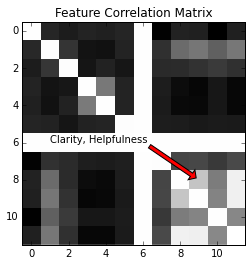

In [29]:
# This calculates the correlation matrix.
feats_corr_matrix = np.corrcoef(train_data_features.drop(['id'], axis=1), rowvar=0)

# This code builds the plot.  Most of the code is to make the image pretty.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Feature Correlation Matrix')
ax.imshow(feats_corr_matrix, interpolation='none', cmap='gray')
ax.annotate('Clarity, Helpfulness', xy=(9, 8), xytext=(1, 6),
            arrowprops=dict(facecolor='red', shrink=0.05))

In the above image, we can quickly see that helpfulness (column 8) and clarity (column 9) enjoy a high correlation (The columns are obviously highly correlated with themselves, which is why the diagonal is so bright).   One way you have probably seen to visually demonstrate correlation between random variables is with a scatter plot.

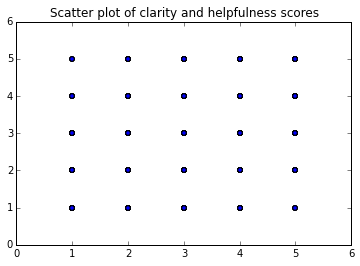

In [33]:
# Create a scatter plot of clarity vs helpfulness scores.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scatter plot of clarity and helpfulness scores")
ax.scatter(train_data_features['clarity'], train_data_features['helpfulness'])

This is really unhelpful.  What is wrong?  What can we do about it?

We need to communicate how frequently each dot in the above graph occurs to really gain any insight here.  What are some ways that we can do that?

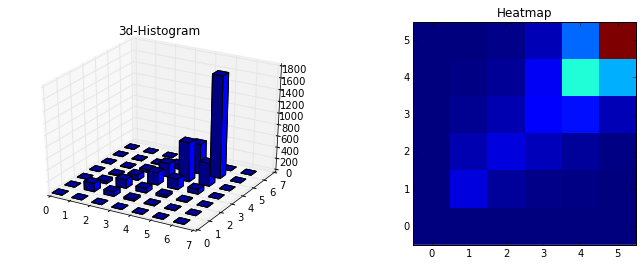

In [48]:
# This creates a histogram. Is this more informative than the scatter plot?
fig = plt.figure()
fig.set_size_inches(12, 4)
ax.set_title("Correlation clarity and helpfulness")
ax = fig.add_subplot(121, projection='3d')

# These values give the range of values the features may take. In
# this example, clarity is on the x axis and helpfulness is on the
# y axis.
xx = np.arange(0,7,1)
yy = np.arange(0,7,1)

# Dealing with 3d graphs is a pain.  What follows is a framework that you
# can use to create your own.
xpos, ypos = np.meshgrid(xx,yy)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(len(ypos))
dx = 0.5*np.ones_like(zpos)
dy = dx.copy()

# The zz values give how tall each bar in our graph is.
zz = np.zeros((len(xx), len(yy)))
for i in range(len(train_data_features['clarity'])):
    zz[train_data_features['clarity'][i], train_data_features['helpfulness'][i]] += 1

# Save the zz matrix to display as an image.
im_zz = zz.copy()
dz = zz.flatten(order='F')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')#, zsort='average')
ax.set_title('3d-Histogram')

# Plot the im_zz matrix as a heatmap.
ax = fig.add_subplot(122)
ax.imshow(im_zz[:-1,:-1], interpolation='none', origin='lower')
ax.set_title('Heatmap')

Take some time to experiment with other features.  

We can take a similar approach to our comment data.  However, because the dataset is so large, it is more work to find interesting correlations.  For example, in the following cell we plot the correlation matrix for the comment data the same way that plotted the non-comment data.  However, since there are so many more columns, we can't just visually pick out which correlations are high.

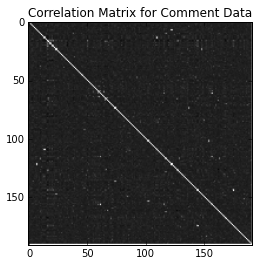

In [51]:
comment_corr_matrix = np.corrcoef(experiment_df.drop(['id'], axis=1), rowvar=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Correlation Matrix for Comment Data")
ax.imshow(comment_corr_matrix, cmap='gray')

Suppose we take a word at random, say word $103$. We can find the words that are most correlated with it by using the numpy.argsort() method.  This will return the indices of the words with the highest correlations in a column.

In [72]:
word_number = 103
words = experiment_df.columns.tolist()
word = words[word_number]

In [82]:
# Use argsort to find the indices of highest correlation with word_number = 103
max_corrs = comment_corr_matrix[:][word_number].argsort()[-1:-6:-1]

You have now been given some tools to explore correlations in the Rate My Professor data set.  Use these tools to explore and visualize correlations that you find interesting and/or surprising.  You might consider looking for correlations amongst words.  Don't forget that you have an extra non-word column in the comment_corr_matrix that might have some interesting correlations in it as well.